---------------

#### analyze newly-culled datasets

In [1]:
import os, sys
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.offsetbox import AnchoredText

import seaborn as sns

path = os.getcwd()


In [2]:

FFNAME = "czapla2022-030"

main_dataset  = pd.read_csv("pdb_res-series-data/czapla2022_pdb-series_res-series_030_data", index_col=0)


### lists and functions:dna_seq_complement

In [3]:
theta_lst = ['tilt','roll','twist','shift','slide','rise']

# --- Lists of dimers, tetramers, and the self-complementary steps ---
BASES     = ['A','C','G','T']
COMP      = {'A':'T', 'T':'A', 'C':'G', 'G':'C','.':'.'}

def dna_seq_complement(sequence_string):
    COMP = {'A':'T', 'T':'A', 'C':'G', 'G':'C','.':'.'}
    STEP = sequence_string[::-1]
    STEP = ''.join([COMP[STEP[i]] for i in range(len(STEP))])
    return STEP

DIMERS    = [b+c for b in BASES for c in BASES]
DIM_MATCH = {'TT':'AA', 'GT':'AC', 'CT':'AG', 'CC':'GG', 'TC':'GA', 'TG':'CA'}
DIMER_LST = ['CG','CA','TA'] + ['AG','GG','AA','GA'] + ['AT','AC','GC']
lstRR = ['AG','GG','AA','GA']
lstYR = ['CG','CA','TA']
lstRY = ['AT','AC','GC']
SCDIM     = []
for DIM in DIMERS:
    if COMP[DIM[1]]+COMP[DIM[0]]==DIM:
        SCDIM.append(DIM)

TET_LST      = [a+b+c+d for a in ['A','C','G','T','.'] for b in BASES for c in BASES for d in ['A','C','G','T','.']]
TETRAMERS    = [i for i in TET_LST if '.' not in i]
TETRAMER_LST = [
    'AAAA','AACA','AAGA','AATA','ACAA','ACGA','AGAA','AGCA','AGGA','ATAA',
    'AAAC','AACC','AAGC','AATC','ACAC','ACGC','AGAC','AGCC','AGGC','ATAC',
    'AAAG','AACG','AAGG','AATG','ACAG','ACGG','AGAG','AGCG','AGGG','ATAG',
    'AAAT','AACT','AAGT','AATT','ACAT','ACGT','AGAT','AGCT','AGGT','ATAT',
    'CAAA','CACA','CAGA','CATA','CCAA','CCGA','CGAA','CGCA','CGGA','CTAA',
    'CAAC','CACC','CAGC','CCAC','CGAC','CGGC','CAAG','CACG','CAGG','CATG',
    'CCAG','CCGG','CGAG','CGCG','CGGG','CTAG','CAAT','CACT','CAGT','CCAT',
    'CGAT','CGGT','GAAA','GACA','GAGA','GATA','GCAA','GCGA','GGAA','GGCA',
    'GGGA','GTAA','GAAC','GACC','GAGC','GATC','GCAC','GCGC','GGAC','GGCC',
    'GGGC','GTAC','GAAG','GACG','GAGG','GATG','GCAG','GCGG','GGAG','GGCG',
    'GGGG','GTAG','GAAT','GACT','GAGT','GCAT','GGAT','GGGT','TAAA','TACA',
    'TAGA','TATA','TCAA','TCGA','TGAA','TGCA','TGGA','TTAA','TAAC','TACC',
    'TAGC','TCAC','TGAC','TGGC','TAAG','TACG','TAGG','TCAG','TGAG','TGGG',
    'TAAT','TACT','TAGT','TCAT','TGAT','TGGT'
]
SCTET        = []
for TET in TETRAMERS:
    if COMP[TET[3]]+COMP[TET[2]]+COMP[TET[1]]+COMP[TET[0]]==TET and '.' not in TET:
        SCTET.append(TET)

In [4]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

---------------------

### MpN Dataset

In [5]:
main_dataset[main_dataset.DIMER=='AA']


,tilt,roll,twist,shift,slide,rise,pdb_id,step_dimer,step_tetramer,dimer_neighbors,coding,DIMER,TETRAMER,resolution
0,-1.5499,2.8513,35.7251,-0.3927,0.4704,3.1545,1MNN,AA,AAAA,A__A,y,AA,AAAA,1.40
1,-0.9655,-2.4252,40.5069,-0.3678,-0.2445,3.5568,1MNN,AA,AAAA,A__A,y,AA,AAAA,1.40
2,3.0479,-6.1206,32.0532,0.0494,-0.5475,3.4192,6BD0,TT,TTTT,T__T,y,AA,AAAA,1.45
3,1.8670,-8.7659,33.8477,0.0242,-0.5947,3.3491,6BDB,TT,TTTT,T__T,y,AA,AAAA,1.50
4,-2.7385,1.6485,35.6724,-0.5284,0.4097,3.1489,2EUZ,AA,AAAA,A__A,y,AA,AAAA,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64088,3.4296,10.8687,41.1466,0.0636,-0.1729,3.1773,8ICX,AA,TAAT,T__T,n,AA,TAAT,3.00
64089,-4.9762,9.2341,37.9602,-0.1603,0.0013,3.4121,9ICA,AA,TAAT,T__T,n,AA,TAAT,3.00
64090,-3.1491,12.4704,32.0614,-0.0278,-0.1999,3.4457,9ICF,AA,TAAT,T__T,n,AA,TAAT,3.00
64091,-2.4937,9.9256,35.0645,-0.1696,-0.0880,3.1695,9ICG,AA,TAAT,T__T,n,AA,TAAT,3.00


In [6]:
mpn_dataset = pd.DataFrame(index=DIMERS)

for STEP in DIMERS:
    mpn_dataset.at[STEP, 'count'] = len( main_dataset[(main_dataset.step_dimer==STEP)] )
    
    for THETA1 in theta_lst:
        mpn_dataset.at[STEP, THETA1] = round(main_dataset.loc[(main_dataset.step_dimer==STEP)][THETA1].mean(), 3)
        
mpn_dataset.at['MN', 'count'] = mpn_dataset['count'].sum()
for THETA1 in theta_lst:
    mpn_dataset.at['MN', THETA1] = round( mpn_dataset[THETA1].sum()/len(DIMERS), 3)
mpn_dataset['count'] = mpn_dataset['count'].astype(int)

mpn_dataset.to_csv(FFNAME+"_par-avg_dimer_structure-space")
del mpn_dataset

In [7]:
mpn_dataset = pd.DataFrame(index=DIMER_LST)

for STEP in DIMER_LST:
    mpn_dataset.at[STEP, 'count'] = len( main_dataset[(main_dataset.DIMER==STEP)] )
    
    for THETA1 in theta_lst:
        mpn_dataset.at[STEP, THETA1] = round(main_dataset.loc[(main_dataset.DIMER==STEP)][THETA1].mean(), 3)
        
mpn_dataset.at['MN', 'count'] = mpn_dataset['count'].sum()
for THETA1 in theta_lst:
    mpn_dataset.at['MN', THETA1] = round( mpn_dataset[THETA1].sum()/len(DIMER_LST), 3)
mpn_dataset['count'] = mpn_dataset['count'].astype(int)

mpn_dataset.to_csv(FFNAME+"_par-avg_unique-dimer_structure-space")
del mpn_dataset

In [8]:
mpn_dataset = pd.DataFrame(index=TETRAMER_LST)

for STEP in TETRAMER_LST:
    mpn_dataset.at[STEP, 'count'] = len( main_dataset[(main_dataset.TETRAMER==STEP)] )
    
    for THETA1 in theta_lst:
        mpn_dataset.at[STEP, THETA1] = round(main_dataset.loc[(main_dataset.TETRAMER==STEP)][THETA1].mean(), 3)
        
mpn_dataset.at['MN', 'count'] = mpn_dataset['count'].sum()
for THETA1 in theta_lst:
    mpn_dataset.at['MN', THETA1] = round( mpn_dataset[THETA1].sum()/len(TETRAMER_LST), 3)
mpn_dataset['count'] = mpn_dataset['count'].astype(int)

mpn_dataset.to_csv(FFNAME+"_par-avg_unique-tetramer_structure-space")
del mpn_dataset

In [9]:
mpn_dataset = pd.DataFrame(index=TETRAMERS)

for STEP in TETRAMERS:
    mpn_dataset.at[STEP, 'count'] = len( main_dataset[(main_dataset.step_tetramer==STEP)] )
    
    for THETA1 in theta_lst:
        mpn_dataset.at[STEP, THETA1] = round(main_dataset.loc[(main_dataset.step_tetramer==STEP)][THETA1].mean(), 3)
        
mpn_dataset.at['MN', 'count'] = mpn_dataset['count'].sum()
for THETA1 in theta_lst:
    mpn_dataset.at['MN', THETA1] = round( mpn_dataset[THETA1].sum()/len(TETRAMERS), 3)
mpn_dataset['count'] = mpn_dataset['count'].astype(int)

mpn_dataset.to_csv(FFNAME+"_par-avg_tetramer_structure-space")

mpn_dataset

,count,tilt,roll,twist,shift,slide,rise
AAAA,482,-0.031,-1.714,36.185,0.011,-0.335,3.250
AAAC,236,-0.366,-0.787,35.073,-0.031,-0.406,3.276
AAAG,217,-0.317,-1.282,35.609,-0.048,-0.371,3.240
AAAT,343,-0.099,-2.532,36.294,0.006,-0.397,3.261
AACA,291,0.037,0.276,32.635,0.012,-0.645,3.308
...,...,...,...,...,...,...,...
TTTA,257,-0.146,-0.016,34.867,-0.025,-0.254,3.249
TTTC,241,-0.367,-0.512,36.208,-0.096,-0.175,3.251
TTTG,264,-0.381,0.310,35.056,-0.072,-0.190,3.277
TTTT,482,0.031,-1.714,36.185,-0.011,-0.335,3.250


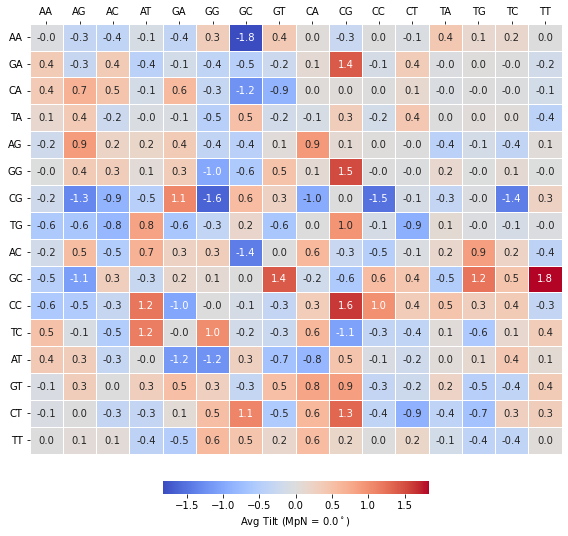

<Figure size 432x288 with 0 Axes>

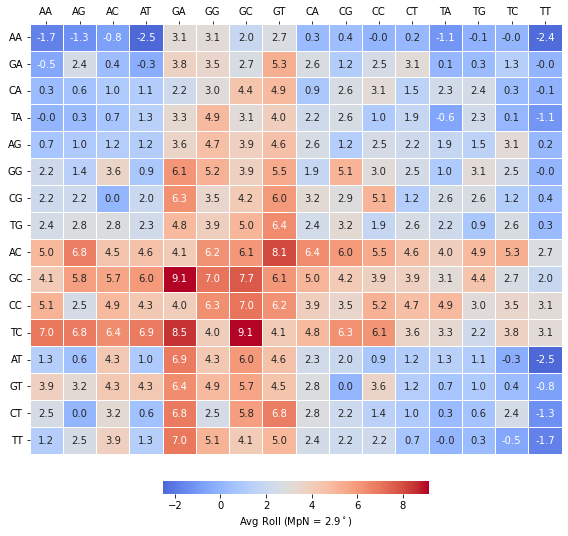

<Figure size 432x288 with 0 Axes>

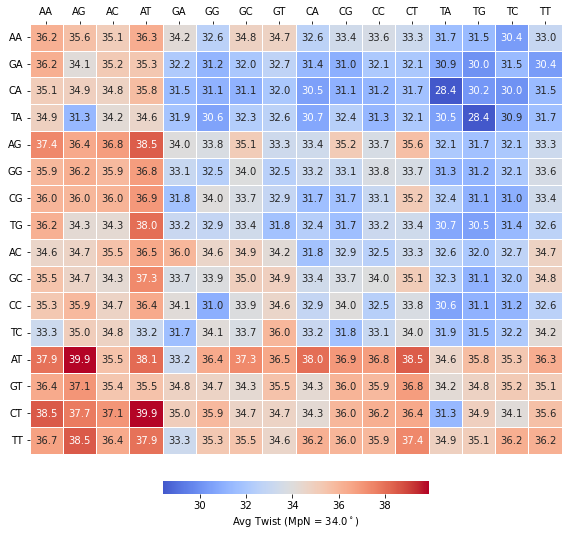

<Figure size 432x288 with 0 Axes>

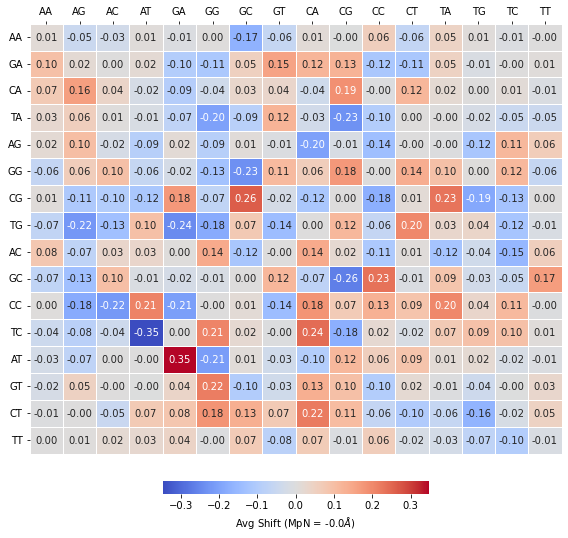

<Figure size 432x288 with 0 Axes>

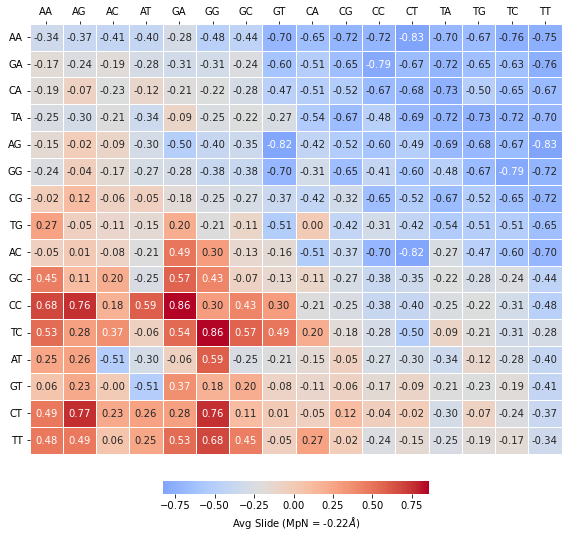

<Figure size 432x288 with 0 Axes>

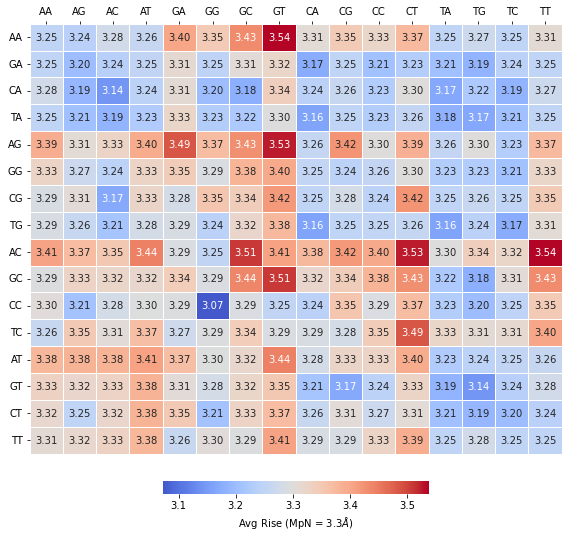

<Figure size 432x288 with 0 Axes>

In [10]:
for THETA in theta_lst:#['twist']:#
    
    plt_df= pd.DataFrame(index=[a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']],
                         columns=[i[::-1] for i in [a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']]]).T
    
    for dim1 in plt_df.index:
        for dim2 in plt_df.columns:
            plt_df.at[dim1, dim2] = mpn_dataset[mpn_dataset.index==dim1+dim2][THETA]
            
    plt_df = plt_df.astype(float)
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    if THETA in ['tilt','roll','twist']:
        formatter = '.1f'
        rounder = 1
        symbol = "$^\circ$"
    else:
        formatter = '.2f'
        rounder = 2
        symbol = "$\AA$"
        
    sns.heatmap(data=plt_df,
                cbar=True, annot=True,fmt=formatter,
                cmap="coolwarm", 
                center=mpn_dataset.at['MN', THETA], #vmin=spread_values[THETA][0], vmax=spread_values[THETA][1],
                cbar_kws={'orientation':'horizontal','pad':0.05, 
                          'label':"Avg "+THETA.capitalize()+" (MpN = {x}{y})".format(x=str(round(mpn_dataset.at['MN', THETA], rounder)), y=symbol),
                          'shrink':0.50},
                linewidths=1,linecolor='white',
                ax=ax)
    del formatter, rounder, symbol
    #plt.title("Tetrameric Averages\n")
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.savefig(FFNAME+"_heatmap_par-avg-tet_"+THETA+"_v01.png", dpi=300)
    plt.show()
    plt.clf()
    
    plt_df.to_csv(FFNAME+"_heatmap_par-avg-tet_"+THETA+"_v01_figdata")
    del plt_df

In [11]:
df1 = mpn_dataset.copy().drop(['MN'], axis=0)

df1['dimer']=mpn_dataset.drop(['MN'], axis=0).index.str[1:3]

mpn_dim_dataset=pd.DataFrame(index=DIMERS)
for STEP in DIMERS:
    mpn_dim_dataset.at[STEP, 'count'] = df1[(df1.dimer==STEP)]['count'].sum()
    
    for THETA1 in theta_lst:
        mpn_dim_dataset.at[STEP, THETA1] = round( df1[(df1.dimer==STEP)][THETA1].sum() / len(df1[(df1.dimer==STEP)]) , 3)
del df1
mpn_dim_dataset.at['MN', 'count'] = mpn_dim_dataset['count'].sum()
for THETA1 in theta_lst:
    mpn_dim_dataset.at['MN', THETA1] = round( mpn_dim_dataset[THETA1].sum()/len(DIMERS), 3)
mpn_dim_dataset['count']=mpn_dim_dataset['count'].astype(int)

mpn_dim_dataset.to_csv(FFNAME+"_par-avg_dimer_tet-seq-space")

mpn_dim_dataset

,count,tilt,roll,twist,shift,slide,rise
AA,3967,0.051,0.071,34.969,0.025,-0.256,3.231
AC,3634,0.137,1.627,31.911,-0.004,-0.644,3.260
AG,3634,-0.291,3.493,32.356,-0.033,-0.336,3.314
AT,5831,0.000,0.231,30.675,-0.000,-0.691,3.226
CA,3830,-0.010,5.382,35.096,-0.046,0.220,3.326
CC,3743,0.140,4.849,33.245,0.031,-0.345,3.366
CG,5432,-0.000,6.486,34.138,0.000,0.352,3.322
CT,3634,0.291,3.493,32.356,0.033,-0.336,3.314
GA,4114,-0.133,1.816,36.351,-0.037,-0.084,3.295
GC,4918,0.000,2.719,33.366,0.000,-0.441,3.284


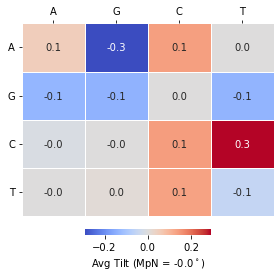

<Figure size 432x288 with 0 Axes>

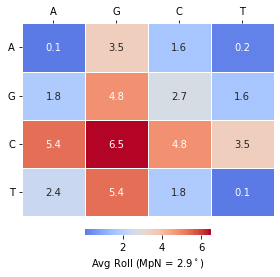

<Figure size 432x288 with 0 Axes>

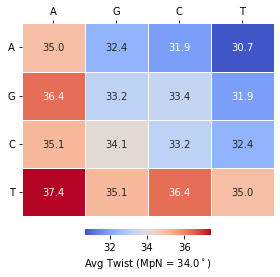

<Figure size 432x288 with 0 Axes>

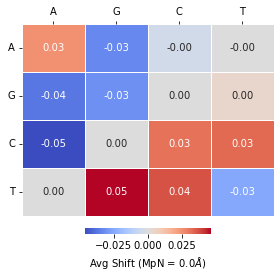

<Figure size 432x288 with 0 Axes>

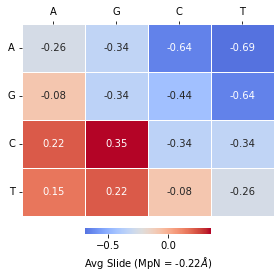

<Figure size 432x288 with 0 Axes>

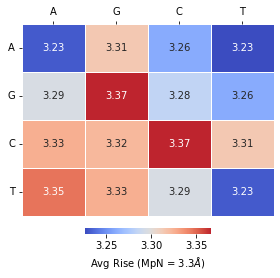

<Figure size 432x288 with 0 Axes>

In [12]:
for THETA in theta_lst:#['twist']:#
    
    plt_df= pd.DataFrame(index=['A','G','C','T'],
                         columns=['A','G','C','T'])
    
    for b1 in plt_df.index:
        for b2 in plt_df.columns:
            plt_df.at[b1, b2] = mpn_dim_dataset[mpn_dim_dataset.index==b1+b2][THETA]
    plt_df = plt_df.astype(float)
    
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    if THETA in ['tilt','roll','twist']:
        formatter = '.1f'
        rounder = 1
        symbol = "$^\circ$"
    else:
        formatter = '.2f'
        rounder = 2
        symbol = "$\AA$"
        
    sns.heatmap(data=plt_df,
                cbar=True, annot=True,fmt=formatter,
                cmap="coolwarm", 
                center=mpn_dim_dataset.at['MN', THETA], #vmin=spread_values[THETA][0], vmax=spread_values[THETA][1],
                cbar_kws={'orientation':'horizontal','pad':0.05, 
                          'label':"Avg "+THETA.capitalize()+" (MpN = {x}{y})".format(x=str(round(mpn_dim_dataset.at['MN', THETA], rounder)), y=symbol),
                          'shrink':0.50},
                linewidths=1,linecolor='white',
                ax=ax)
    del formatter, rounder, symbol
    #plt.title("Tetrameric Averages\n")
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.savefig(FFNAME+"_heatmap_par-avg-dim_"+THETA+"_v01.png", dpi=300)
    plt.show()
    plt.clf()
    
    plt_df.to_csv(FFNAME+"_heatmap_par-avg-dim_"+THETA+"_v01_figdata")
    del plt_df

In [13]:
del mpn_dataset, mpn_dim_dataset

### Dataset comparative analysis

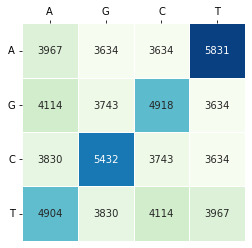

<Figure size 432x288 with 0 Axes>

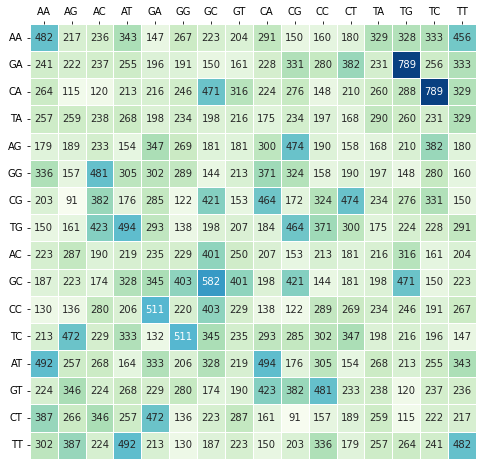

<Figure size 432x288 with 0 Axes>

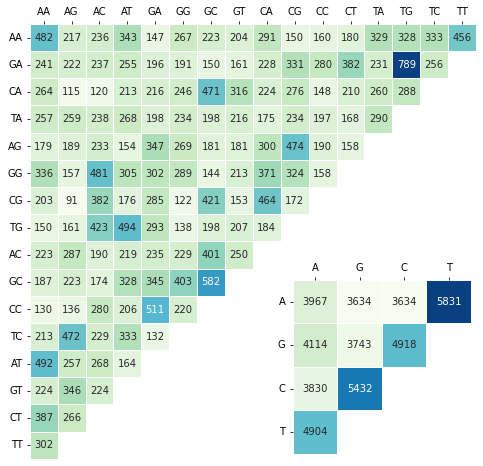

<Figure size 432x288 with 0 Axes>

In [32]:
dimer_lst_02 = [a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']]
dimer_df     = pd.DataFrame(index=['A','G','C','T'],columns=['A','G','C','T'])

for b1 in dimer_df.index:
    for b2 in dimer_df.columns:
        dimer_df.at[b1, b2] = len( main_dataset.loc[main_dataset.step_dimer==b1+b2] )
dimer_df=dimer_df.astype(int)

tetramer_df = pd.DataFrame(index=[i for i in dimer_lst_02],
                           columns=[i[::-1] for i in dimer_lst_02]).T
del dimer_lst_02
for dim1 in tetramer_df.index:
    for dim2 in tetramer_df.columns:
        tetramer_df.at[dim1, dim2]= len( main_dataset.loc[main_dataset.step_tetramer==dim1+dim2] )
tetramer_df=tetramer_df.astype(int)

fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(data=dimer_df,
            cbar=False, annot=True,fmt='d',
            cmap="GnBu",
            linewidths=1,linecolor='white',
           ax=ax)
#plt.title(FFNAME+" Tetramers\n")
ax.xaxis.tick_top()
plt.yticks(rotation=0)
plt.savefig(FFNAME+"_heatmap_count-dimer-all_v01.png", dpi=300)
plt.show()
plt.clf()

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(data=tetramer_df,
            cbar=False, annot=True,fmt='d',
            cmap="GnBu",
            linewidths=1,linecolor='white',
           ax=ax)
#plt.title(FFNAME+" Tetramers\n")
ax.xaxis.tick_top()
plt.yticks(rotation=0)
plt.savefig(FFNAME+"_heatmap_count-tetramer-all_v01.png", dpi=300)
plt.show()
plt.clf()


dimer_df.to_csv(FFNAME+"_heatmap_count-dimer-all_v01_figdata")
tetramer_df.to_csv(FFNAME+"_heatmap_count-tetramer-all_v01_figdata")

for b1 in dimer_df.index:
    for b2 in dimer_df.columns:
        if b1+b2 not in DIMER_LST:
            dimer_df.at[b1, b2] = 0
for dim1 in tetramer_df.index:
    for dim2 in tetramer_df.columns:
        if dim1+dim2 not in TETRAMER_LST:
            tetramer_df.at[dim1, dim2]= 0

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=tetramer_df,
            cbar=False, annot=True,fmt='d',
            cmap="GnBu",
            linewidths=1,linecolor='white',
            mask=( tetramer_df==0 ),
           ax=ax)
ax.xaxis.tick_top()
plt.yticks(rotation=0)

axins = inset_axes(ax,  "40%", "40%" ,loc="lower right", borderpad=0.5)
sns.heatmap(data=dimer_df,
            cbar=False, annot=True,fmt='d',
            cmap="GnBu",
            linewidths=1,linecolor='white', 
            mask=( dimer_df==0 ),
           ax=axins)
#plt.title("Dimer Count\n")
axins.xaxis.tick_top()
plt.yticks(rotation=0)
plt.savefig(FFNAME+"_heatmap_count-dim+tet-all_v01.png", dpi=300)
plt.show()
plt.clf()

del dimer_df, tetramer_df

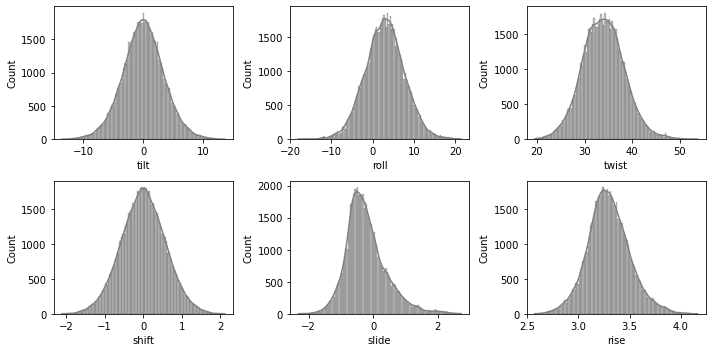

<Figure size 432x288 with 0 Axes>

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(10,5))

tlst = ['tilt','roll','twist']
for i in range(len(tlst)):
    sns.histplot(data=main_dataset, x=tlst[i], kde=True,
                color="grey", alpha=0.50, ax=axes[0][i])
    
tlst = ['shift','slide','rise']
for i in range(len(tlst)):
    sns.histplot(data=main_dataset, x=tlst[i], kde=True,
                color="gray", alpha=0.50, ax=axes[1][i])

del tlst

plt.tight_layout()
plt.savefig(FFNAME+"_hist-kde_dim-tet_full-dataset_parameters_01.png", dpi=300)
plt.show()
plt.clf()

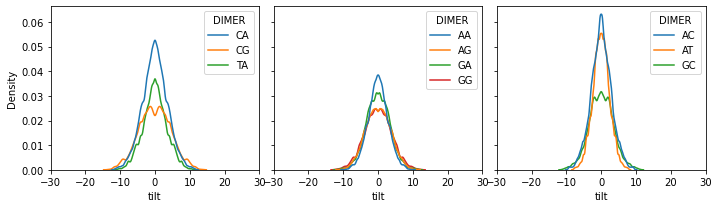

<Figure size 432x288 with 0 Axes>

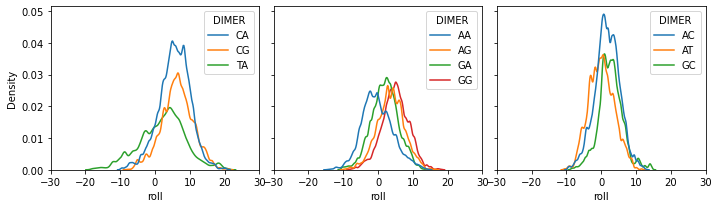

<Figure size 432x288 with 0 Axes>

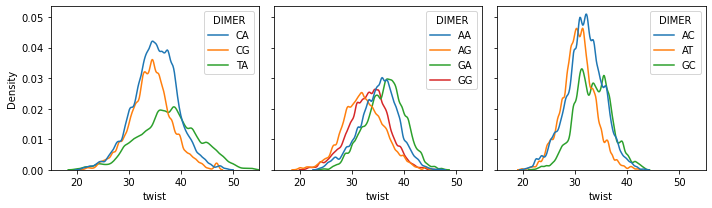

<Figure size 432x288 with 0 Axes>

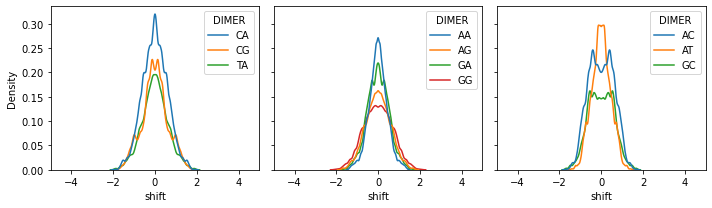

<Figure size 432x288 with 0 Axes>

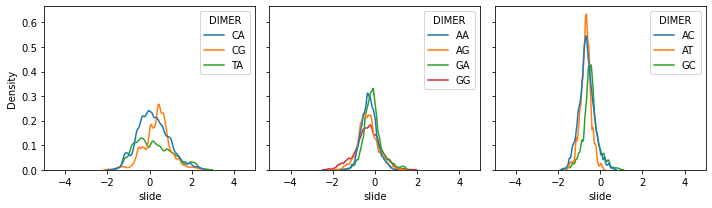

<Figure size 432x288 with 0 Axes>

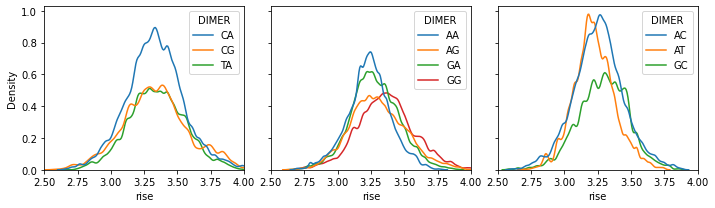

<Figure size 432x288 with 0 Axes>

In [34]:
limits = {'tilt':[-30, 30], 'roll':[-30, 30], 'twist':[15,55], 'shift':[-5,5], 'slide':[-5,5], 'rise':[2.5, 4.0]}

for PAR in ['tilt','roll','twist','shift','slide','rise']:
    
    fig, axes = plt.subplots(1,3, figsize=(10,3), sharey=True)
    
    pltdf = main_dataset.copy().loc[(main_dataset.DIMER.isin(lstYR))].reset_index(drop=True)
    sns.kdeplot(data=pltdf,
                x=PAR, hue="DIMER",
                bw_adjust=0.5, ax=axes[0])
    del pltdf
    
    pltdf = main_dataset.copy().loc[(main_dataset.DIMER.isin(lstRR))].reset_index(drop=True)
    sns.kdeplot(data=pltdf,
                x=PAR, hue="DIMER",
                bw_adjust=0.5, ax=axes[1])
    del pltdf
    
    pltdf = main_dataset.copy().loc[(main_dataset.DIMER.isin(lstRY))].reset_index(drop=True)
    sns.kdeplot(data=pltdf,
                x=PAR, hue="DIMER",
                bw_adjust=0.5, ax=axes[2])
    del pltdf
    
    for ax in axes:
        ax.set_xlim(limits[PAR][0], limits[PAR][1])
    
    plt.tight_layout()
    plt.show()
    plt.clf()
    
del limits

____________________________________________

### Analysis of culled dimeric datasets

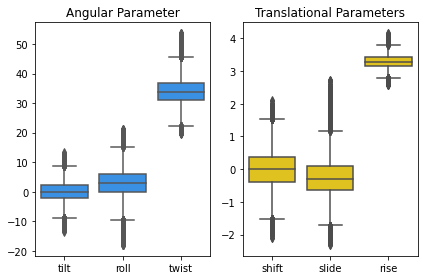

<Figure size 432x288 with 0 Axes>

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6,4))

sns.boxplot(data=main_dataset[['tilt','roll','twist']], color='dodgerblue', ax=axes[0])
sns.boxplot(data=main_dataset[['shift','slide','rise']],  color='gold', ax=axes[1])
axes[0].set_title("Angular Parameter")
axes[1].set_title("Translational Parameters")  

plt.tight_layout()
plt.savefig(FFNAME+"_mpn-dist-boxplot_v01.png", dpi=300)
plt.show()
plt.clf()

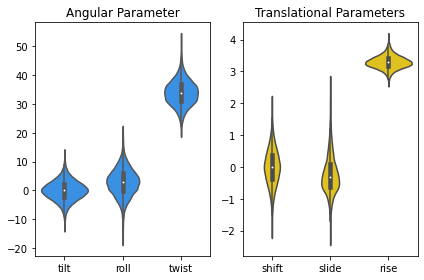

<Figure size 432x288 with 0 Axes>

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6,4))

sns.violinplot(data=main_dataset[['tilt','roll','twist']], 
               color='dodgerblue', 
               ax=axes[0])


sns.violinplot(data=main_dataset[['shift','slide','rise']], 
               color='gold', 
               ax=axes[1])

axes[0].set_title("Angular Parameter")
axes[1].set_title("Translational Parameters")  


plt.tight_layout()
plt.savefig(FFNAME+"_mpn-dist-violinplot_v01.png", dpi=300)
plt.show()
plt.clf()

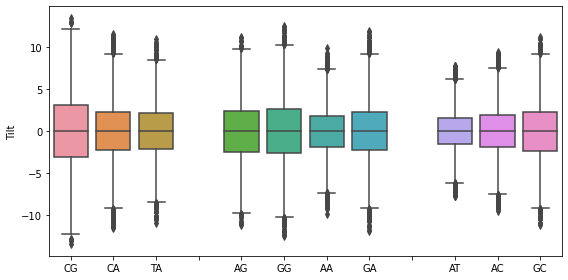

<Figure size 432x288 with 0 Axes>

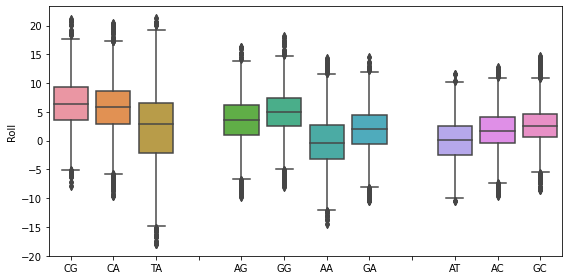

<Figure size 432x288 with 0 Axes>

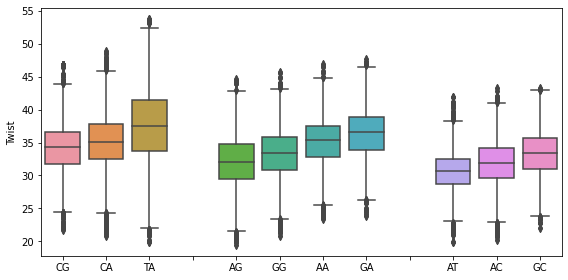

<Figure size 432x288 with 0 Axes>

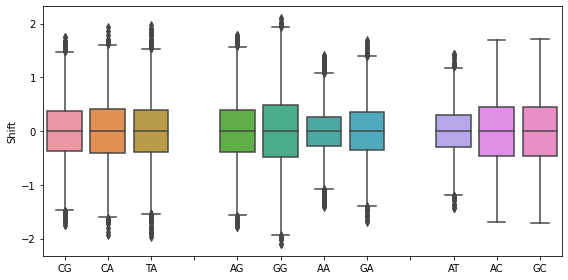

<Figure size 432x288 with 0 Axes>

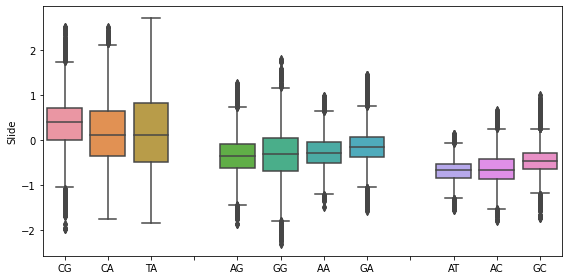

<Figure size 432x288 with 0 Axes>

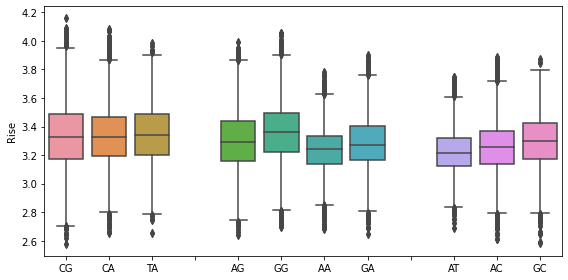

<Figure size 432x288 with 0 Axes>

In [17]:
for theta in theta_lst:
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    
    dlst = DIMER_LST[0:3]+['']+DIMER_LST[3:7]+['']+DIMER_LST[7:]
    
    sns.boxplot(data=main_dataset,
                x="DIMER",
                y=theta,
                order=dlst, 
                ax=ax)
    plt.xlabel('')
    plt.ylabel(theta.capitalize())
    plt.tight_layout()
    plt.savefig(FFNAME+"_dists-violin-"+theta+"-dim_01.png", dpi=300)
    plt.show()
    plt.clf()


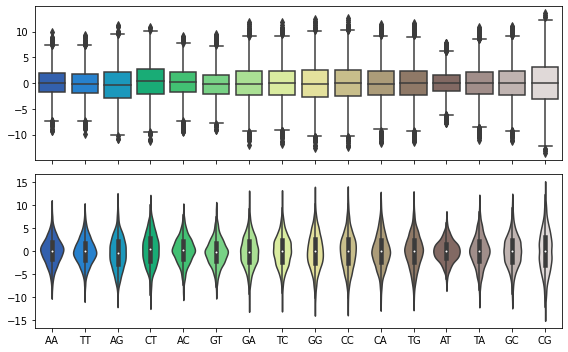

<Figure size 432x288 with 0 Axes>

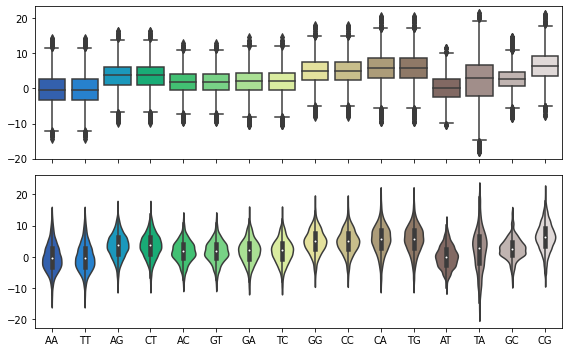

<Figure size 432x288 with 0 Axes>

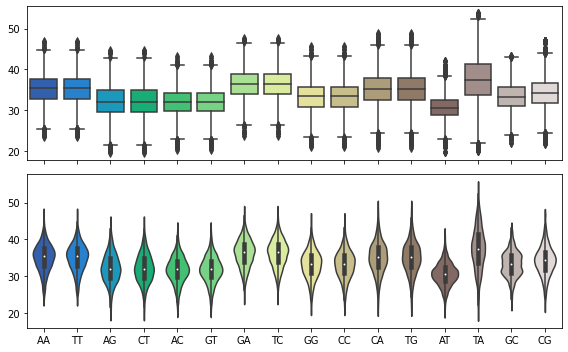

<Figure size 432x288 with 0 Axes>

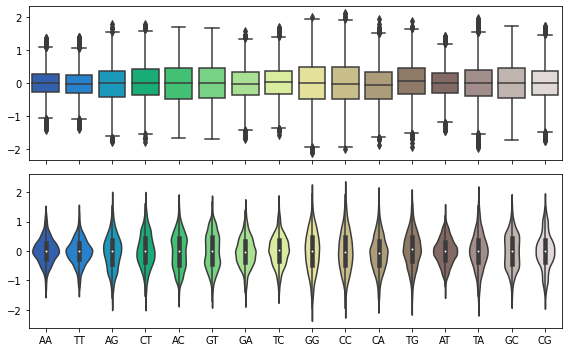

<Figure size 432x288 with 0 Axes>

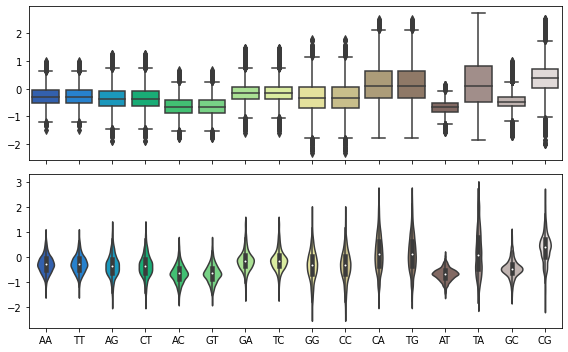

<Figure size 432x288 with 0 Axes>

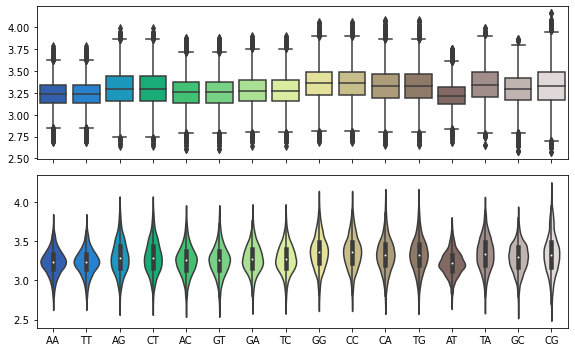

<Figure size 432x288 with 0 Axes>

In [18]:
for theta in theta_lst:
    
    fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)
    sns.boxplot(data=main_dataset,
                   x="step_dimer", 
                   y=theta,
                   order=['AA','TT','AG','CT','AC','GT','GA','TC','GG','CC','CA','TG','AT','TA','GC','CG'], 
                   palette='terrain',
                   ax=axes[0])
    
    sns.violinplot(data=main_dataset,
                   x="step_dimer", 
                   y=theta,
                   order=['AA','TT','AG','CT','AC','GT','GA','TC','GG','CC','CA','TG','AT','TA','GC','CG'], 
                   palette='terrain',
                   ax=axes[1])
    for ax in axes:
        ax.set(ylabel="", xlabel="")
    plt.tight_layout()
    plt.savefig(FFNAME+"_dists-violin-"+theta+"-dim_01.png", dpi=300)
    plt.show()
    plt.clf()




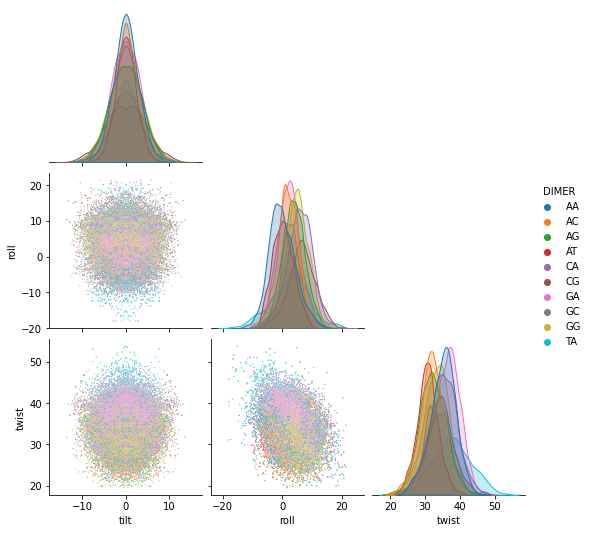

<Figure size 432x288 with 0 Axes>

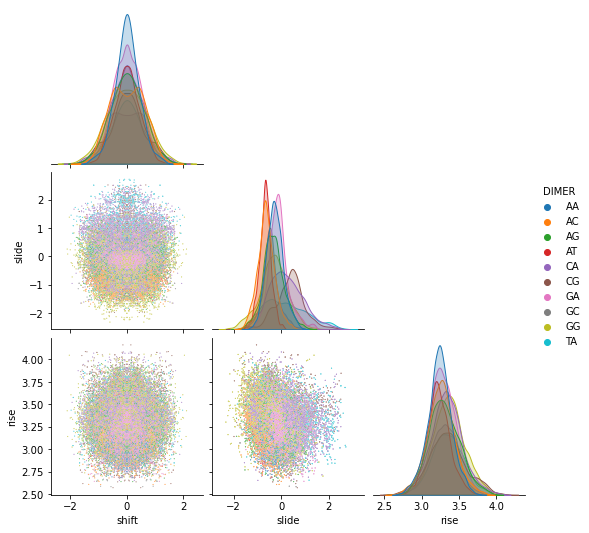

<Figure size 432x288 with 0 Axes>

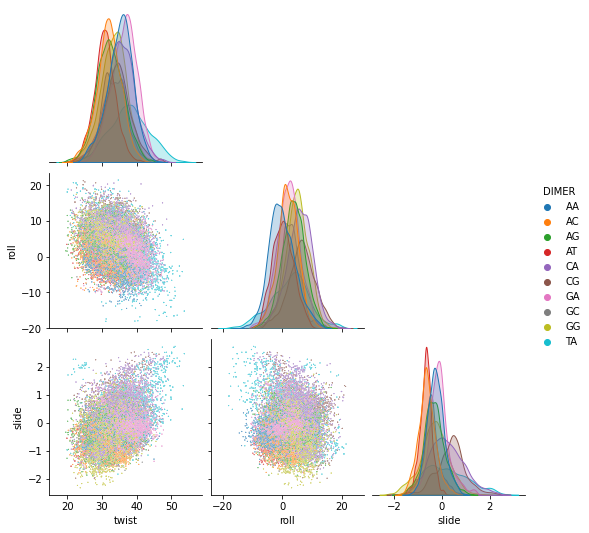

<Figure size 432x288 with 0 Axes>

In [19]:
pltdf = main_dataset.copy()

sns.pairplot(data=pltdf,
             x_vars=['tilt','roll','twist'],
             y_vars=['tilt','roll','twist'],
             hue='DIMER',  
             corner=True,
             markers='.', plot_kws={'s':5})
plt.show()
#plt.savefig("czapla2022_par-scatter+dists_full_v01", dpi=300)
plt.clf()

sns.pairplot(data=pltdf,
             x_vars=['shift','slide','rise'],
             y_vars=['shift','slide','rise'],
             hue='DIMER',  
             corner=True,
             markers='.', plot_kws={'s':5})
plt.show()
#plt.savefig("czapla2022_par-scatter+dists_full_v01", dpi=300)
plt.clf()

sns.pairplot(data=pltdf,
             x_vars=['twist','roll','slide'],
             y_vars=['twist','roll','slide'],
             hue='DIMER',  
             corner=True,
             markers='.', plot_kws={'s':5})
plt.show()
#plt.savefig("czapla2022_par-scatter+dists_full_v01", dpi=300)
plt.clf()

del pltdf

KeyboardInterrupt: 

<Figure size 864x864 with 0 Axes>

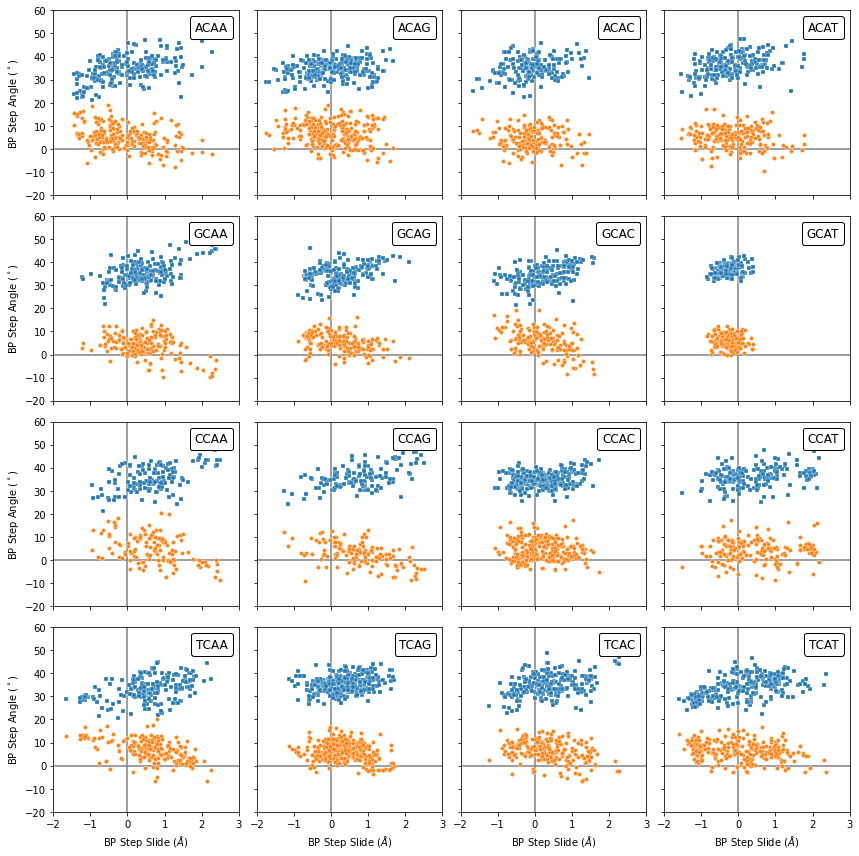

In [20]:
X = "slide"
Y1 = "twist"
Y2 = "roll"

pltdf = main_dataset.copy()

# Try: make a 4x4 figure based on the 10|16 tetramers with respect to central dimer

for dim in DIMER_LST:
    
    fig, axes = plt.subplots(4,4,figsize=(12,12), sharex='col', sharey='row')
    
    bases=['A','G','C','T']
    axes_dict={bases[i]+dim+bases[j]:[i, j] for i in range(len(bases)) for j in range(len(bases))}
    
    tetlen16=False
    tet_lst = [bases[i]+dim+bases[j] for i in range(len(bases)) for j in range(len(bases))]
    if len( [i for i in tet_lst if i in TETRAMER_LST] ) == 16:
        tetlen16=True
    
    for i in range(0, 4):
        for j in range(0, 4):
            
            tetstep = bases[i]+dim+bases[j]
            
            if tetstep in TETRAMER_LST:
            
                sns.scatterplot(data=pltdf.loc[pltdf.TETRAMER==tetstep], 
                                x=X, y=Y1, 
                                legend=False,#label=tetstep,
                                marker='s', s=15, 
                               ax=axes[i, j])

                sns.scatterplot(data=pltdf.loc[pltdf.TETRAMER==tetstep], 
                                x=X, y=Y2, 
                                legend=False,#label=tetstep,
                                marker='o', s=15, 
                               ax=axes[i, j])

                at = AnchoredText(tetstep, prop=dict(size=12), frameon=True, loc='upper right')
                at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                axes[i, j].add_artist(at)
                axes[i, j].set(ylim=(-20,60), ylabel='BP Step Angle ($^\circ$)', xlim=(-2,3), xlabel='BP Step Slide ($\AA$)')
                axes[i, j].axhline(y=0, color="grey", zorder=0)
                axes[i, j].axvline(x=0, color="grey", zorder=0)  
                
                del at
            
            del tetstep
            
    if tetlen16 == False:
        fig.delaxes(axes[3][1])
        fig.delaxes(axes[2][2])
        fig.delaxes(axes[3][2])
        fig.delaxes(axes[1][3])
        fig.delaxes(axes[2][3])
        fig.delaxes(axes[3][3])
  
    del bases, axes_dict, tet_lst, tetlen16  
    #plt.legend(title=tet, loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.savefig(FFNAME+"_scatter_tw-ro-sl_"+dim+"_4x4_v01.png", dpi=300)
    #plt.show()
    plt.clf()

del pltdf

In [ ]:
X = "slide"
Y1 = "twist"
Y2 = "roll"

pltdf = main_dataset.copy()

# Try: make a 4x4 figure based on the 10|16 tetramers with respect to central dimer

for dim in DIMER_LST:
    
    fig, axes = plt.subplots(4,4,figsize=(12,12), sharex='col', sharey='row')
    
    bases=['A','G','C','T']
    axes_dict={bases[i]+dim+bases[j]:[i, j] for i in range(len(bases)) for j in range(len(bases))}
    
    tetlen16=False
    tet_lst = [bases[i]+dim+bases[j] for i in range(len(bases)) for j in range(len(bases))]
    if len( [i for i in tet_lst if i in TETRAMER_LST] ) == 16:
        tetlen16=True
    
    for i in range(0, 4):
        for j in range(0, 4):
            
            tetstep = bases[i]+dim+bases[j]
            
            sns.regplot(data=pltdf.loc[pltdf.TETRAMER==tetstep], 
                        x=X, y=Y1, 
                        fit_reg=True, truncate=False,
                        scatter=True, ci=68, 
                        scatter_kws={"marker":'o', "s":15, 'alpha':0.50, 'edgecolor':'white'},
                        ax=axes[i, j])

            sns.regplot(data=pltdf.loc[pltdf.TETRAMER==tetstep], 
                        x=X, y=Y2, 
                        fit_reg=True, truncate=False,
                        scatter=True,ci=68, 
                        scatter_kws={"marker":'o', "s":15, 'alpha':0.50, 'edgecolor':'white'},
                        ax=axes[i, j])

            at = AnchoredText(tetstep, prop=dict(size=12), frameon=True, loc='upper right')
            at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            axes[i, j].add_artist(at)
            axes[i, j].set(ylim=(-20,60), ylabel='BP Step Angle ($^\circ$)', xlim=(-2,3), xlabel='BP Step Slide ($\AA$)')
            axes[i, j].axhline(y=0, color="grey", zorder=0)
            axes[i, j].axvline(x=0, color="grey", zorder=0)  

            del at
            del tetstep
            
    if tetlen16 == False:
        fig.delaxes(axes[3][1])
        fig.delaxes(axes[2][2])
        fig.delaxes(axes[3][2])
        fig.delaxes(axes[1][3])
        fig.delaxes(axes[2][3])
        fig.delaxes(axes[3][3])
  
    del bases, axes_dict, tet_lst, tetlen16  
    #plt.legend(title=tet, loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.savefig(FFNAME+"_scatter+linreg_tw-ro-sl_"+dim+"_4x4_v01.png", dpi=300)
    #plt.show()
    plt.clf()

del pltdf

In [ ]:
X = "slide"
Y1 = "twist"
Y2 = "roll"

pltdf = main_dataset.copy()

# Try: make a 4x4 figure based on the 10|16 tetramers with respect to central dimer

for dim in DIMER_LST:
    
    fig, axes = plt.subplots(4,4,figsize=(12,12), sharex='col', sharey='row')
    
    bases=['A','G','C','T']
    axes_dict={bases[i]+dim+bases[j]:[i, j] for i in range(len(bases)) for j in range(len(bases))}
    
    tetlen16=False
    tet_lst = [bases[i]+dim+bases[j] for i in range(len(bases)) for j in range(len(bases))]
    if len( [i for i in tet_lst if i in TETRAMER_LST] ) == 16:
        tetlen16=True
    
    for i in range(0, 4):
        for j in range(0, 4):
            
            tetstep = bases[i]+dim+bases[j]
            axes[i, j].scatter(x=pltdf.loc[pltdf.TETRAMER==tetstep].slide,
                               y=pltdf.loc[pltdf.TETRAMER==tetstep].roll,
                               color='tab:orange', marker='o', s=15, alpha=0.50, edgecolor='white')
            confidence_ellipse(pltdf.loc[pltdf.TETRAMER==tetstep].slide,
                               pltdf.loc[pltdf.TETRAMER==tetstep].roll,
                               axes[i, j], 
                               n_std=3,
                               label=None,
                               edgecolor='tab:orange', linestyle='--', linewidth=2.5, zorder=1)
            
            axes[i, j].scatter(x=pltdf.loc[pltdf.TETRAMER==tetstep].slide,
                               y=pltdf.loc[pltdf.TETRAMER==tetstep].twist,
                               color='tab:blue', marker='s', s=15, alpha=0.50, edgecolor='white')
            confidence_ellipse(pltdf.loc[pltdf.TETRAMER==tetstep].slide,
                               pltdf.loc[pltdf.TETRAMER==tetstep].twist,
                               axes[i, j], 
                               n_std=3,
                               label=None,
                               edgecolor='tab:blue', linestyle='--', linewidth=2.5, zorder=1)
            
            at = AnchoredText(tetstep, prop=dict(size=12), frameon=True, loc='upper right')
            at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            axes[i, j].add_artist(at)
            axes[i, j].set(ylim=(-20,60), ylabel='BP Step Angle ($^\circ$)', xlim=(-2,3), xlabel='BP Step Slide ($\AA$)')
            axes[i, j].axhline(y=0, color="grey", zorder=0)
            axes[i, j].axvline(x=0, color="grey", zorder=0)  

            del at
            del tetstep
            
    if tetlen16 == False:
        fig.delaxes(axes[3][1])
        fig.delaxes(axes[2][2])
        fig.delaxes(axes[3][2])
        fig.delaxes(axes[1][3])
        fig.delaxes(axes[2][3])
        fig.delaxes(axes[3][3])
  
    del bases, axes_dict, tet_lst, tetlen16  
    #plt.legend(title=tet, loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    #plt.show()
    plt.savefig(FFNAME+"_scatter+conellipses_tw-ro-sl-_"+dim+"_4x4_v01.png", dpi=300)
    plt.clf()

del pltdf

------------

### Tetrameric Bar plot, in context of central dimer

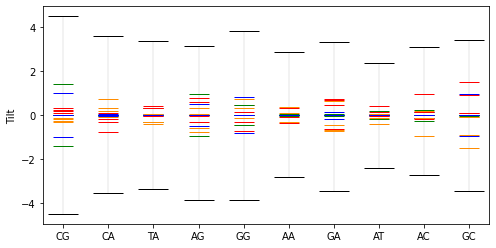

<Figure size 432x288 with 0 Axes>

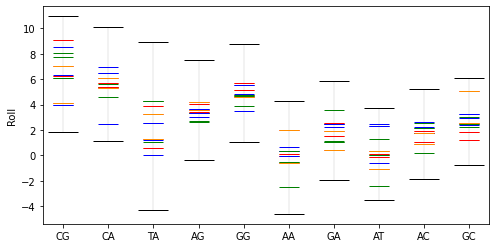

<Figure size 432x288 with 0 Axes>

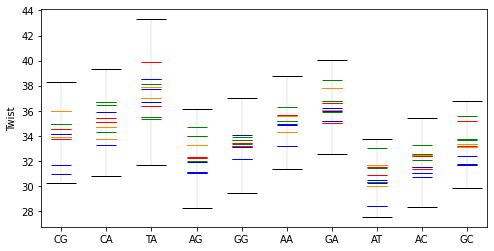

<Figure size 432x288 with 0 Axes>

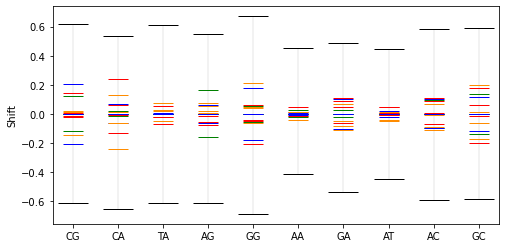

<Figure size 432x288 with 0 Axes>

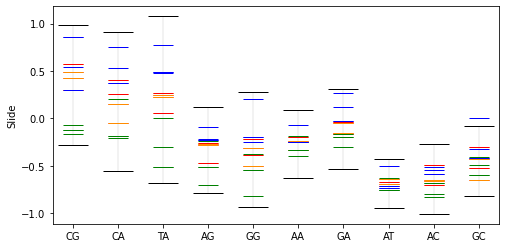

<Figure size 432x288 with 0 Axes>

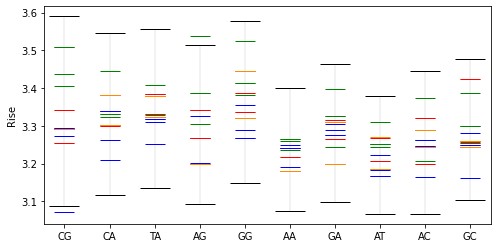

<Figure size 432x288 with 0 Axes>

In [21]:
band_colors = {'A__A':'red','A__G':'red','G__A':'red','G__G':'red',
               'A__T':'green','A__C':'green','G__T':'green','G__C':'green',
               'T__A':'blue','C__A':'blue','T__G':'blue','C__G':'blue',
               'T__T':'darkorange', 'C__C':'darkorange','C__T':'darkorange','T__C':'darkorange'}

dataset = main_dataset.copy()       
df_dets = pd.DataFrame(index=DIMER_LST)


for STEP in dataset.step_dimer.unique():
    df_dets.at[STEP, "count"] = dataset.loc[(dataset.step_dimer==STEP)]['tilt'].count()
    for THETA in theta_lst:
        df_dets.at[STEP, THETA+"_mean"] = dataset.loc[(dataset.step_dimer==STEP)][THETA].mean()
        df_dets.at[STEP, THETA+"_std"]  = dataset.loc[(dataset.step_dimer==STEP)][THETA].std() 


for THETA in theta_lst:
    df = pd.DataFrame(columns=[i for i in dataset.dimer_neighbors.unique() if "." not in i],
                      index=dataset.DIMER.unique())
    
    for STEP in DIMERS:   
        for NN in [i for i in dataset.dimer_neighbors.unique()]:
            df.at[STEP, NN] = dataset.loc[(dataset.DIMER==STEP)&(dataset.dimer_neighbors==NN)][THETA].mean()
    
    df         = df.drop([i for i in DIMERS if i not in DIMER_LST], axis=0)
    pltdf_dets = df_dets.copy().drop([i for i in DIMERS if i not in DIMER_LST], axis=0)
    
    
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    ax.errorbar(x=pltdf_dets.index,
                y=pltdf_dets[THETA+"_mean"], yerr=pltdf_dets[THETA+"_std"], 
                fmt='none',
                ecolor="black", elinewidth=0.1,capsize=15)
    for NN in df.columns:
        plt.plot(df.index, df[NN], 
                 color=band_colors[NN], 
                 marker='_', ms=20, linestyle="None", alpha=1.0)
    ax.set_ylabel(THETA.capitalize())
    
    plt.savefig(FFNAME+"_tet-box_pdb-data_"+THETA+"_v01.png", dpi=300)
    plt.show()
    plt.clf()
    del df, pltdf_dets

del dataset
del band_colors

In [ ]:
df_dets

-------------

### Heatmap of average parameters

In [22]:
tet_dataset = pd.read_csv(FFNAME+"_par-avg_tetramer_structure-space", index_col=0)
dim_copy    = pd.read_csv(FFNAME+"_par-avg_dimer_tet-seq-space", index_col=0)
dim_dataset = pd.DataFrame(columns=dim_copy.columns)

for step in DIMER_LST:
    if step in SCDIM:
        dim_dataset.loc[step]=dim_copy.loc[step]
        
    elif step != 'MN':
        dim_dataset.at[step, 'count']= dim_copy.at[step, 'count'] + dim_copy.at[dna_seq_complement(step), 'count']
        for theta in theta_lst:
            dim_dataset.at[step, theta]= dim_copy.at[step, theta]

dim_dataset.loc['MN']=dim_copy.loc['MN']
dim_dataset['count']=dim_dataset['count'].astype(int)
del dim_copy



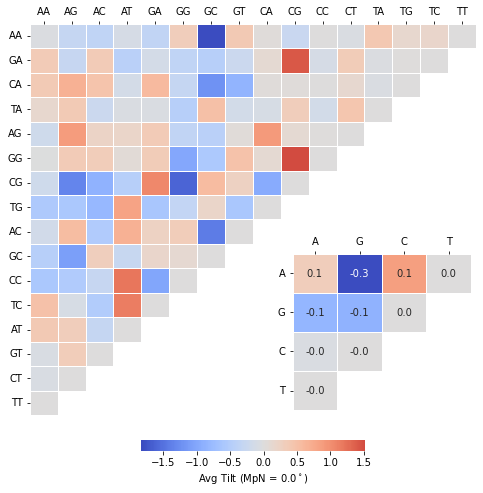

<Figure size 432x288 with 0 Axes>

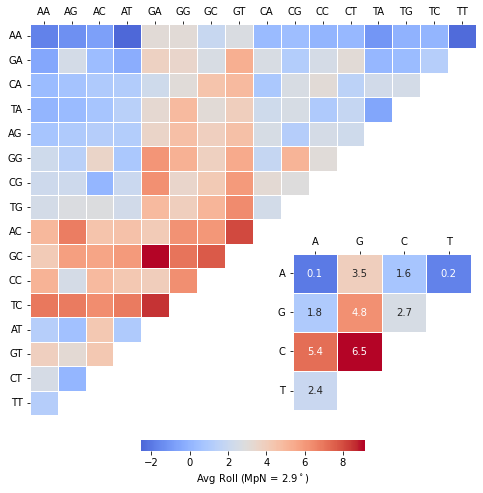

<Figure size 432x288 with 0 Axes>

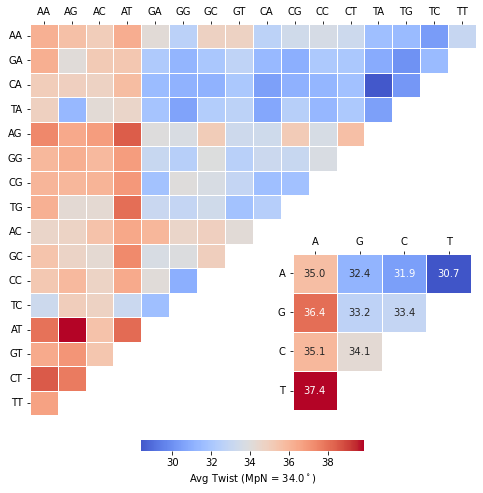

<Figure size 432x288 with 0 Axes>

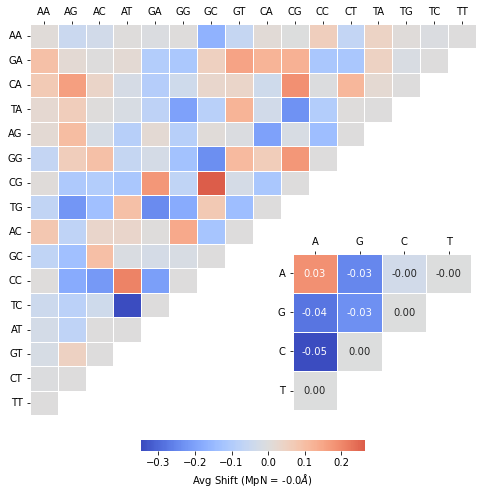

<Figure size 432x288 with 0 Axes>

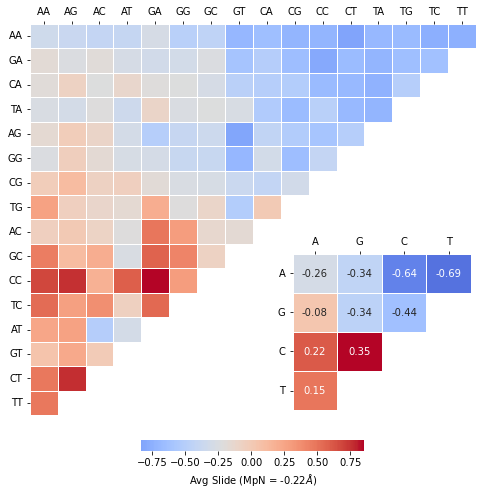

<Figure size 432x288 with 0 Axes>

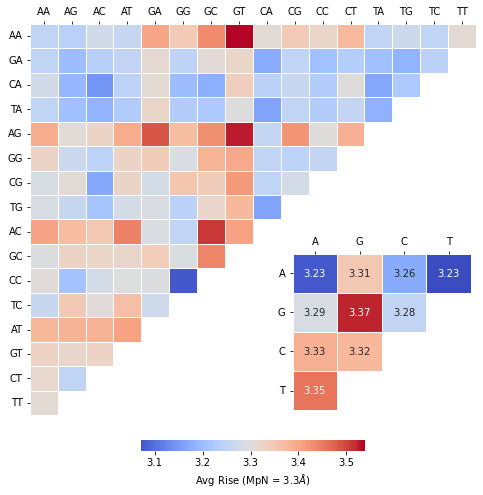

<Figure size 432x288 with 0 Axes>

In [23]:
for theta in theta_lst:#['twist']#

    dimer_par_df  = pd.DataFrame(index=['A','G','C','T'],columns=['A','G','C','T'])
    lst           = [a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']]
    tetra_par_df  = pd.DataFrame(index=[i[::-1] for i in lst], columns=lst)
    del lst

    for b1 in dimer_par_df.index:
        for b2 in dimer_par_df.columns:
            step=b1+b2
            if step in DIMER_LST:
                dimer_par_df.at[b1, b2] = dim_dataset.at[step,theta]
            else:
                dimer_par_df.at[b1, b2]=np.nan
            del step

    for t1 in tetra_par_df.index:
        for t2 in tetra_par_df.columns:
            step=t1+t2
            if step in TETRAMER_LST:
                tetra_par_df.at[t1, t2] = tet_dataset.at[step,theta]
            else:
                tetra_par_df.at[t1, t2]=np.nan
            del step
    
    dimer_par_df = dimer_par_df.astype(float)
    tetra_par_df = tetra_par_df.astype(float)
    
    fig, ax = plt.subplots(figsize=(8,9))
    if theta in ['tilt','roll','twist']:
        formatter = '.1f'
        rounder = 1
        symbol = "$^\circ$"
        #spread=5
    else:
        formatter = '.2f'
        rounder = 2
        symbol = "$\AA$"
        #spread=0.75
        
    sns.heatmap(data=tetra_par_df,
                cbar=True, #annot=True,fmt='.2f',
                cmap="coolwarm", 
                center=tet_dataset.at['MN',theta], 
                #vmin=tet_dataset.at['MN',theta]-spread, vmax=tet_dataset.at['MN',theta]+spread,
                cbar_kws={'orientation':'horizontal','pad':0.05, 
                          'label':"Avg "+theta.capitalize()+" (MpN = {x}{y})".format(x=str(round(tet_dataset.at['MN',theta], rounder)), y=symbol),
                          'shrink':0.50},
                linewidths=1,linecolor='white',
                mask=( tetra_par_df.isna() ),
                ax=ax)
    #ax.set_title("Tetrameric Averages\n")
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    axins = inset_axes(ax, "40%", "40%" ,loc="lower right", borderpad=0.5)
    sns.heatmap(data=dimer_par_df,
                cbar=False, annot=True,fmt=formatter,
                cmap="coolwarm", 
                center=tet_dataset.at['MN',theta], 
                #vmin=tet_dataset.at['MN',theta]-spread, vmax=tet_dataset.at['MN',theta]+spread,
                #cbar_kws={'orientation':'horizontal','pad':0.05, 
                #          'label':"Avg "+theta.capitalize(),
                #          'shrink':0.50},
                linewidths=1,linecolor='white', 
                mask=( dimer_par_df.isna() ),
                ax=axins)
    
    plt.yticks(rotation=0)
    axins.xaxis.tick_top()
    #axins.patch.set(edgecolor='black', linewidth='1')
    
    del formatter, rounder, symbol#, spread
    
    #plt.tight_layout()
    plt.savefig(FFNAME+"_heatmap_par-avg_tet-strucspace+dim-seq-space_"+theta+"_v01.png", dpi=300)
    plt.show()
    plt.clf()
    
    dimer_par_df.to_csv(FFNAME+"_heatmap_par-avg_tet-strucspace+dim-seq-space_"+theta+"_v01-dimer_figdata")
    tetra_par_df.to_csv(FFNAME+"_heatmap_par-avg_tet-strucspace+dim-seq-space_"+theta+"_v01-tetramer_figdata")

    del dimer_par_df, tetra_par_df


In [24]:
tet_dataset = pd.read_csv(FFNAME+"_par-avg_tetramer_structure-space", index_col=0)
dim_copy    = pd.read_csv(FFNAME+"_par-avg_dimer_structure-space", index_col=0)
dim_dataset = pd.DataFrame(columns=dim_copy.columns)

for step in DIMER_LST:
    if step in SCDIM:
        dim_dataset.loc[step]=dim_copy.loc[step]
    elif step != 'MN':
        dim_dataset.at[step, 'count']= dim_copy.at[step, 'count'] + dim_copy.at[dna_seq_complement(step), 'count']
        for theta in theta_lst:
            dim_dataset.at[step, theta]= dim_copy.at[step, theta]

dim_dataset.loc['MN']=dim_copy.loc['MN']
dim_dataset['count']=dim_dataset['count'].astype(int)
del dim_copy

#dim_dataset

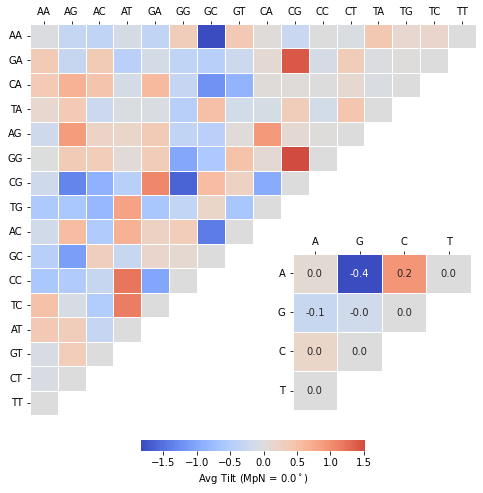

<Figure size 432x288 with 0 Axes>

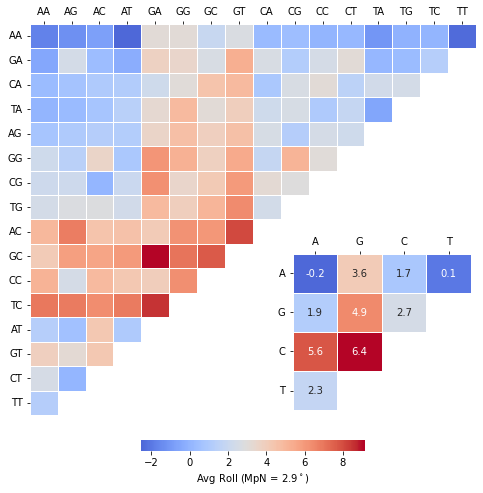

<Figure size 432x288 with 0 Axes>

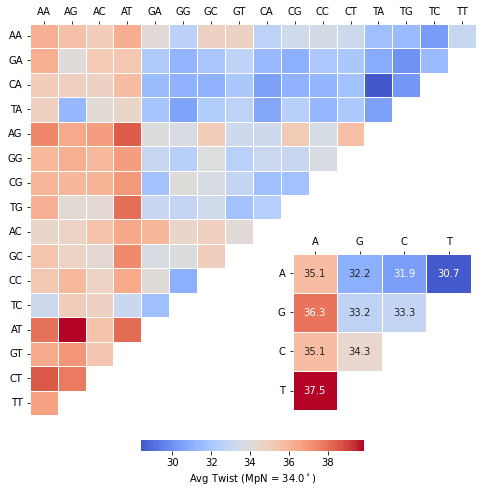

<Figure size 432x288 with 0 Axes>

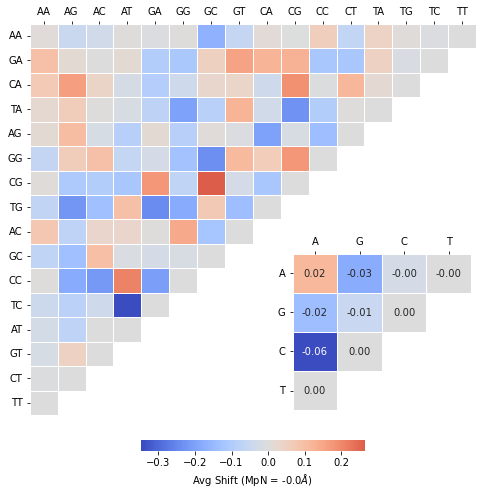

<Figure size 432x288 with 0 Axes>

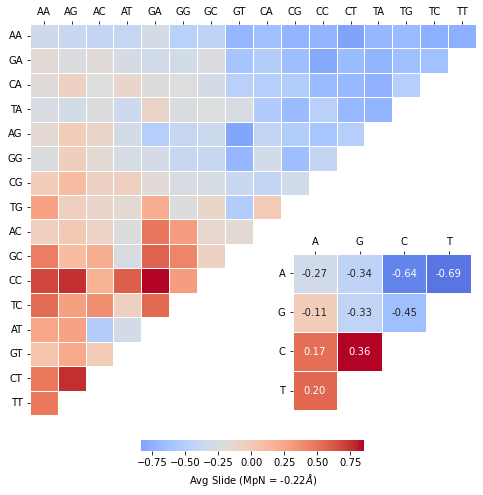

<Figure size 432x288 with 0 Axes>

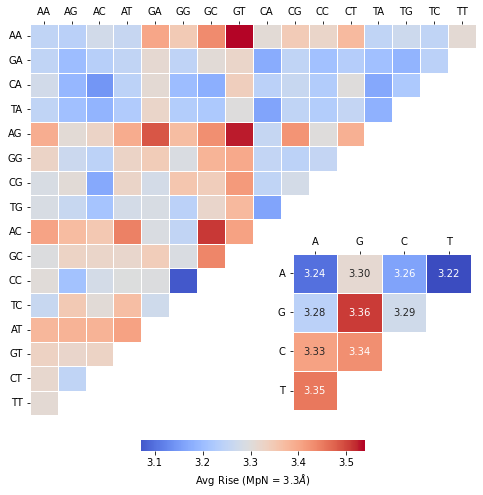

<Figure size 432x288 with 0 Axes>

In [25]:
for theta in theta_lst:#['twist']#

    dimer_par_df  = pd.DataFrame(index=['A','G','C','T'],columns=['A','G','C','T'])
    lst           = [a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']]
    tetra_par_df  = pd.DataFrame(index=[i[::-1] for i in lst], columns=lst)
    del lst

    for b1 in dimer_par_df.index:
        for b2 in dimer_par_df.columns:
            step=b1+b2
            if step in DIMER_LST:
                dimer_par_df.at[b1, b2] = dim_dataset.at[step,theta]
            else:
                dimer_par_df.at[b1, b2]=np.nan
            del step

    for t1 in tetra_par_df.index:
        for t2 in tetra_par_df.columns:
            step=t1+t2
            if step in TETRAMER_LST:
                tetra_par_df.at[t1, t2] = tet_dataset.at[step,theta]
            else:
                tetra_par_df.at[t1, t2]=np.nan
            del step
    
    dimer_par_df = dimer_par_df.astype(float)
    tetra_par_df = tetra_par_df.astype(float)
    
    fig, ax = plt.subplots(figsize=(8,9))
    if theta in ['tilt','roll','twist']:
        formatter = '.1f'
        rounder = 1
        symbol = "$^\circ$"
        #spread=5
    else:
        formatter = '.2f'
        rounder = 2
        symbol = "$\AA$"
        #spread=0.75
        
    sns.heatmap(data=tetra_par_df,
                cbar=True, #annot=True,fmt='.2f',
                cmap="coolwarm", 
                center=tet_dataset.at['MN',theta], 
                #vmin=tet_dataset.at['MN',theta]-spread, vmax=tet_dataset.at['MN',theta]+spread,
                cbar_kws={'orientation':'horizontal','pad':0.05, 
                          'label':"Avg "+theta.capitalize()+" (MpN = {x}{y})".format(x=str(round(tet_dataset.at['MN',theta], rounder)), y=symbol),
                          'shrink':0.50},
                linewidths=1,linecolor='white',
                mask=( tetra_par_df.isna() ),
                ax=ax)
    #ax.set_title("Tetrameric Averages\n")
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    axins = inset_axes(ax, "40%", "40%" ,loc="lower right", borderpad=0.5)
    sns.heatmap(data=dimer_par_df,
                cbar=False, annot=True,fmt=formatter,
                cmap="coolwarm", 
                center=tet_dataset.at['MN',theta], 
                #vmin=tet_dataset.at['MN',theta]-spread, vmax=tet_dataset.at['MN',theta]+spread,
                #cbar_kws={'orientation':'horizontal','pad':0.05, 
                #          'label':"Avg "+theta.capitalize(),
                #          'shrink':0.50},
                linewidths=1,linecolor='white', 
                mask=( dimer_par_df.isna() ),
                ax=axins)
    
    plt.yticks(rotation=0)
    axins.xaxis.tick_top()
    #axins.patch.set(edgecolor='black', linewidth='1')
    
    del formatter, rounder, symbol#, spread
    
    #plt.tight_layout()
    plt.savefig(FFNAME+"_heatmap_par-avg_tet-strucspace+dim-strucspace_"+theta+"_v01.png", dpi=300)
    plt.show()
    plt.clf()
    
    dimer_par_df.to_csv(FFNAME+"_heatmap_par-avg_tet-strucspace+dim-strucspace_"+theta+"_v01-dimer_figdata")
    tetra_par_df.to_csv(FFNAME+"_heatmap_par-avg_tet-strucspace+dim-strucspace_"+theta+"_v01-tetramer_figdata")

    del dimer_par_df, tetra_par_df


In [27]:
for THETA in theta_lst:#['twist']:#
    
    dim2_df  = pd.DataFrame(index=['A','G','C','T'],columns=['A','G','C','T'])
    seqspace_data = pd.read_csv("pdb_time-series-data/czapla2022_pdb-series_year-series_"+THETA+"-dim-seq-space_jan2022", index_col=0)
    
    for b1 in dim2_df.index:
        for b2 in dim2_df.columns:
            if b1+b2 in DIMER_LST:
                dim2_df.at[b1, b2] = seqspace_data.at[b1+b2,'2022']
            else:
                dim2_df.at[b1, b2] = 0
            
    dim2_lst = [a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']]
    tet2_df  = pd.DataFrame(index=[i for i in dim2_lst],columns=[i[::-1] for i in dim2_lst]).T
    del dim2_lst
    for dim1 in tet2_df.index:
        for dim2 in tet2_df.columns:
            tet2_df.at[dim1, dim2] = mpn_dataset[mpn_dataset.TETRAMER==dim1+dim2][THETA].mean()
            
            
    dim2_df = dim2_df.astype(float)        
    tet2_df = tet2_df.astype(float)
    
    
    fig, ax = plt.subplots(figsize=(8,9))
    
    sns.heatmap(data=tet2_df,
                cbar=True, #annot=True,fmt='.2f',
                cmap="coolwarm", center=center_values[THETA], vmin=spread_values[THETA][0], vmax=spread_values[THETA][1],
                cbar_kws={'orientation':'horizontal','pad':0.05, 'label':"Avg "+THETA.capitalize(),'shrink':0.50},
                linewidths=1,linecolor='white',
                mask=( tet2_df==0 ),
                ax=ax)
    plt.title("Tetrameric Averages\n")
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    axins = inset_axes(ax,  "35%", "35%" ,loc="lower right", borderpad=0.5)
    
    if THETA in ['tilt','roll','twist']:
        formatter= ".1f"
    else:
        formatter= ".2f"
    
    sns.heatmap(data=dim2_df,
                cbar=False, annot=True,fmt=formatter,
                cmap="coolwarm", center=center_values[THETA], vmin=spread_values[THETA][0], vmax=spread_values[THETA][1],
                cbar_kws={'orientation':'horizontal','pad':0.05, 'label':"Avg "+THETA.capitalize(),'shrink':0.50},
                linewidths=1,linecolor='white', 
                mask=( dim2_df==0 ),
                ax=axins)
    axins.xaxis.tick_top()
    plt.title("Dimeric Averages")
    
    
    plt.yticks(rotation=0)
    #plt.tight_layout()
    plt.show()
    #plt.savefig(FFNAME+"_heatmap-avg-"+THETA+"-seq-space_v01.png", dpi=300)
    plt.clf()
    
    #tet2_df.to_csv(FFNAME+"_heatmap-avg-"+THETA+"-seq-space_figdata")

    del dim2_df, tet2_df

FileNotFoundError: [Errno 2] No such file or directory: 'pdb_time-series-data/czapla2022_pdb-series_year-series_tilt-dim-seq-space_jan2022'

In [ ]:
spread_values2={'tilt':[mpn_dataset['tilt'].mean() - 5, mpn_dataset['tilt'].mean() + 5],
               'roll':[mpn_dataset['roll'].mean() - 5, mpn_dataset['roll'].mean() + 5],
               'twist':[mpn_dataset['twist'].mean() - 5, mpn_dataset['twist'].mean() + 5],
               'shift':[mpn_dataset['shift'].mean() - 0.75, mpn_dataset['shift'].mean() + 0.75],
               'slide':[mpn_dataset['slide'].mean() - 0.75, mpn_dataset['slide'].mean() + 0.75],
               'rise':[mpn_dataset['rise'].mean() - 0.75, mpn_dataset['rise'].mean() + 0.75]}

for THETA in theta_lst:#['twist']:
    
    dim2_df  = pd.DataFrame(index=['A','G','C','T'],columns=['A','G','C','T'])
    seqspace_data = pd.read_csv("pdb_time-series-data/czapla2022_pdb-series_year-series_"+THETA+"-dim-seq-space_jan2022", index_col=0)
    
    for b1 in dim2_df.index:
        for b2 in dim2_df.columns:
            if b1+b2 in DIMER_LST:
                dim2_df.at[b1, b2] = seqspace_data.at[b1+b2,'2022']
            else:
                dim2_df.at[b1, b2] = 0
            
    dim2_lst = [a+b for a in ['A','G','C','T'] for b in ['A','G','C','T']]
    tet2_df  = pd.DataFrame(index=[i for i in dim2_lst],columns=[i[::-1] for i in dim2_lst]).T
    del dim2_lst
    for dim1 in tet2_df.index:
        for dim2 in tet2_df.columns:
            tet2_df.at[dim1, dim2] = mpn_dataset[mpn_dataset.TETRAMER==dim1+dim2][THETA].mean()
            
            
    dim2_df = dim2_df.astype(float)        
    tet2_df = tet2_df.astype(float)
    
    
    fig, ax = plt.subplots(figsize=(8,9))
    if THETA in ['tilt','roll','twist']:
        formatter= ".1f"
    else:
        formatter= ".2f"
        
    sns.heatmap(data=tet2_df,
                cbar=True, #annot=True,fmt='.2f',
                cmap="coolwarm", center=center_values[THETA], vmin=spread_values2[THETA][0], vmax=spread_values2[THETA][1],
                cbar_kws={'orientation':'horizontal','pad':0.05, 'label':"Avg "+THETA.capitalize(),'shrink':0.50},
                linewidths=1,linecolor='white',
                mask=( tet2_df==0 ),
                ax=ax)
    plt.title("Tetrameric Averages\n")
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    axins = inset_axes(ax,  "35%", "35%" ,loc="lower right", borderpad=0.5)
    

    
    sns.heatmap(data=dim2_df,
                cbar=False, annot=True,fmt=formatter,
                cmap="coolwarm", center=center_values[THETA], vmin=spread_values2[THETA][0], vmax=spread_values2[THETA][1],
                cbar_kws={'orientation':'horizontal','pad':0.05, 'label':"Avg "+THETA.capitalize(),'shrink':0.50},
                linewidths=1,linecolor='white', 
                mask=( dim2_df==0 ),
                ax=axins)
    if THETA in ['tilt','roll','twist']:
        for t in axins.texts: t.set_text(t.get_text() + "$^\circ$")
    else:
        for t in axins.texts: t.set_text(t.get_text() + "$\AA$")
    axins.xaxis.tick_top()
    plt.title("Dimeric Averages")
    
    
    plt.yticks(rotation=0)
    #plt.tight_layout()
    plt.show()
    #plt.savefig(FFNAME+"_heatmap-avg-"+THETA+"-seq-space_v02.png", dpi=300)
    plt.clf()
    
    #tet2_df.to_csv(FFNAME+"_heatmap-avg-"+THETA+"-seq-space_figdata")

    del dim2_df, tet2_df
del spread_values2

------------------------------

### Eigenvalue analysis of force constants

In [30]:
fcdf = pd.read_csv("pdb_res-series-data/ForceConstants_czapla2022_res030_tet.txt",
                   index_col=0,
                   header=None,
                   #names=['twist','tilt','roll','shift','slide','rise'],
                   sep=',\s+|={',
                   engine='python'
                  )
fcdf[36]=fcdf[36].map(lambda x: x.rstrip('},'))
fcdf=fcdf.astype(float)

eval_tet_df = pd.DataFrame(index=TETRAMER_LST, columns=["eigenvalue_product"]+theta_lst)
eval_dim_df = pd.DataFrame(index=DIMER_LST,  columns=["eigenvalue_product"]+theta_lst)

for STEP in fcdf.index:
    
    mat       = np.reshape(fcdf.loc[STEP].to_numpy(), (6,6))
    eigen_inv = np.linalg.eig( np.linalg.inv(mat) )[0]
    
    if STEP in TETRAMER_LST:
        eval_tet_df.at[STEP, "eigenvalue_product"] = np.prod( eigen_inv )
        for i in range(len(theta_lst)):
            eval_tet_df.at[STEP, theta_lst[i]] = eigen_inv[i]
    else:
        if STEP[1:3] in DIMER_LST:# and '.' in STEP:        
            eval_dim_df.at[STEP[1:3], "eigenvalue_product"] = np.prod( eigen_inv )
            for i in range(len(theta_lst)):
                eval_dim_df.at[STEP[1:3], theta_lst[i]] = eigen_inv[i]
    #del mat, eigen_inv


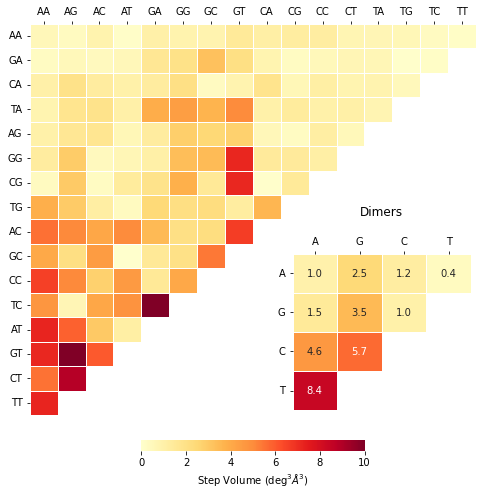

<Figure size 432x288 with 0 Axes>

In [31]:
dimer_data_df = pd.DataFrame(index=['A','G','C','T'],
                             columns=['A','G','C','T'])
tmp_dimer_lst = [i+j for i in ['A','G','C','T'] for j in ['A','G','C','T']]
tet_data_df   = pd.DataFrame(index=[i[::-1] for i in tmp_dimer_lst],
                             columns=[i for i in tmp_dimer_lst])
del tmp_dimer_lst

for b1 in dimer_data_df.index:
    for b2 in dimer_data_df.columns:
        
        if b1+b2 in eval_dim_df.index:
            dimer_data_df.at[b1, b2] = np.sqrt( eval_dim_df.at[b1+b2, 'eigenvalue_product'] )
        else:
            dimer_data_df.at[b1, b2] = 0

for dim1 in tet_data_df.index:
    for dim2 in tet_data_df.columns:
        
        if dim1+dim2 in eval_tet_df.index:
            tet_data_df.at[dim1, dim2] = np.sqrt( eval_tet_df.at[dim1+dim2, 'eigenvalue_product'] )
        else:
            tet_data_df.at[dim1, dim2] = 0
        
dimer_data_df = dimer_data_df.astype(float)       
tet_data_df   = tet_data_df.astype(float)

DATAMIN = 0#np.sqrt( eval_tet_df['eigenvalue_product'].min() )
DATAMAX = 10#np.sqrt( eval_tet_df['eigenvalue_product'].max() )

fig, ax = plt.subplots(figsize=(8,9))

sns.heatmap(data=tet_data_df,
            cbar=True, #annot=True,fmt='.1f',
            cmap="YlOrRd", vmin=DATAMIN, vmax=DATAMAX,
            cbar_kws={'orientation':'horizontal','pad':0.05, 'shrink':0.50, 'label':'Step Volume (deg$^3$$\AA$$^3$)'},
            linewidths=1,linecolor='white',
            mask=( tet_data_df==0 ),
           ax=ax)
#plt.title("Eigenvalue Products\n")
ax.xaxis.tick_top()
plt.yticks(rotation=0)

axins = inset_axes(ax,  "40%", "40%" ,loc="lower right", borderpad=0.5)
sns.heatmap(data=dimer_data_df,
            cbar=False, annot=True,fmt='.1f',
            cmap="YlOrRd", vmin=DATAMIN, vmax=DATAMAX,
            #cbar_kws={'orientation':'horizontal','pad':0.05, 'shrink':0.50, 'label':'sqrt(eigenvalue product)'},
            linewidths=1,linecolor='white', 
            mask=( dimer_data_df==0 ),
           ax=axins)
plt.title("Dimers\n")
axins.xaxis.tick_top()
plt.yticks(rotation=0)

del DATAMIN, DATAMAX

#plt.tight_layout()
plt.savefig(FFNAME+"_heatmap_eigenvalue-analysis_v01.png", dpi=300)
plt.show()
plt.clf()

tet_data_df.to_csv(FFNAME+"_heatmap_eigenvalue-analysis_v01_tetramer-figdata")
dimer_data_df.to_csv(FFNAME+"_heatmap_eigenvalue-analysis_v01_dimer-figdata")

del tet_data_df, dimer_data_df

------------------------------

### Scratch

In [ ]:
pltdf = main_dataset.copy()

# Plot 1- RY dimer steps
fig, axis0 = plt.subplots(1,1,figsize=(7,7))
axis0.scatter(x=pltdf[pltdf.step_dimer.isin(lstRY)].twist,
            y=pltdf[pltdf.step_dimer.isin(lstRY)].roll,
            marker='.', s=5,
            color='black',edgecolor='none')

coloring=['red','blue','green']
colors={lstRY[i]:coloring[i] for i in range(len(lstRY))} 
for DIM in lstRY:
    confidence_ellipse(pltdf[pltdf.step_dimer==DIM].twist,
                       pltdf[pltdf.step_dimer==DIM].roll,
                       axis0, 
                       n_std=3,
                       label=DIM,
                       edgecolor=colors[DIM], linestyle='--', linewidth=2.5, zorder=1)
plt.show()
plt.clf()

# Plot 2- YR dimer steps
fig, axis0 = plt.subplots(1,1,figsize=(7,7))
axis0.scatter(x=pltdf[pltdf.step_dimer.isin(lstYR)].twist,
            y=pltdf[pltdf.step_dimer.isin(lstYR)].roll,
            marker='.', s=5,
            color='black',edgecolor='none')

coloring=['red','blue','green']
colors={lstYR[i]:coloring[i] for i in range(len(lstYR))} 
for DIM in lstYR:
    confidence_ellipse(pltdf[pltdf.step_dimer==DIM].twist,
                       pltdf[pltdf.step_dimer==DIM].roll,
                       axis0, 
                       n_std=3,
                       label=DIM,
                       edgecolor=colors[DIM], linestyle='--', linewidth=2.5, zorder=1)
plt.show()
plt.clf()

# Plot 3- RR dimer steps
fig, axis0 = plt.subplots(1,1,figsize=(7,7))
axis0.scatter(x=pltdf[pltdf.step_dimer.isin(lstRR)].twist,
            y=pltdf[pltdf.step_dimer.isin(lstRR)].roll,
            marker='.', s=5,
            color='black',edgecolor='none')

coloring=['red','blue','green', 'gold']
colors={lstRR[i]:coloring[i] for i in range(len(lstRR))} 
for DIM in lstRR:
    confidence_ellipse(pltdf[pltdf.step_dimer==DIM].twist,
                       pltdf[pltdf.step_dimer==DIM].roll,
                       axis0, 
                       n_std=3,
                       label=DIM,
                       edgecolor=colors[DIM], linestyle='--', linewidth=2.5, zorder=1)
plt.show()
plt.clf()